In [143]:
# First, let's import all libraries that we will need
import pandas as pd
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
import osmnx as ox
import folium
import plotly.express as px
from sodapy import Socrata
from keplergl import KeplerGl

# Now that we have a good understanding of the incident report data, let's take a look at San Francisco recreation and park data
## Importing the Park Data
### San Francisco Recreation and Parks Properties - The data includes land owned and/or maintained by the SF Recreation and Parks Department. 

In [144]:
# This is data for San Francisco Recreation and Park Spaces
parkgeo = gpd.read_file('Recreation and Parks Properties.geojson')

In [145]:
# This is data for San Francisco Neighborhood Boundaries
neighborhoods = gpd.read_file('SF Find Neighborhoods.geojson')

## Getting a First Look at the Data


In [146]:
# How many rows and columns?
parkgeo.shape

(236, 32)

In [147]:
parkgeo.head()

,squarefeet,state_assembly,city,zipcode,acres,propertytype,police_district,realtor_neighborhood,ggp_section,latitude,...,state_senate,ownership,map_label,address,created_user,last_edited_date,psa,last_edited_user,complex,geometry
0,87675.99885853,17th Assembly District,San Francisco,94111,2.01276398,Civic Plaza or Square,Central,Financial District/Barbary Coast,None,37.7955308,...,11th Senatorial District,Real Estate,Maritime Plaza,285 Washington Street,rpdgis,20190329212222,PSA1,RPDGIS@RPDGIS.SFGOV.ORG,North Beach Complex,"MULTIPOLYGON (((-122.39908 37.79596, -122.3982..."
1,26505654.42121903,19th Assembly District,San Francisco,94132,608.4860977,Regional Park,Taraval,Lake Shore,None,37.7219234,...,11th Senatorial District,PUC/Clean Water Program,Lake Merced Park,Lake Merced Boulevard,rpdgis,20190329212222,PSA4,RPDGIS@RPDGIS.SFGOV.ORG,Lake Merced Complex,"MULTIPOLYGON (((-122.48624 37.70816, -122.4862..."
2,6489.2547279,17th Assembly District,San Francisco,94109,0.14897279,Mini Park,Central,Nob Hill,None,37.79642235,...,11th Senatorial District,Public Works,Broadway Tunnel West Mini Park,1201 Broadway,rpdgis,20190329212223,PSA1,RPDGIS@RPDGIS.SFGOV.ORG,North Beach Complex,"MULTIPOLYGON (((-122.41757 37.79649, -122.4175..."
3,1773406.32935865,17th Assembly District,San Francisco,94127,40.71180762,Regional Park,Ingleside,Miraloma Park,None,37.73906281,...,11th Senatorial District,Recreation & Park,Mt. Davidson Park,Myra Way,rpdgis,20190329212223,PSA4,RPDGIS@RPDGIS.SFGOV.ORG,Lake Merced Complex,"MULTIPOLYGON (((-122.45309 37.74097, -122.4530..."
4,113243.32434104,17th Assembly District,San Francisco,94108,2.59970898,Civic Plaza or Square,Central,Downtown,None,37.78793123,...,11th Senatorial District,Recreation & Park,Union Square,Post & Stockton,rpdgis,20190329212223,PSA2,RPDGIS@RPDGIS.SFGOV.ORG,Civic Center/Potrero Hill Complex,"MULTIPOLYGON (((-122.40672 37.78765, -122.4074..."


In [148]:
# Let's see how many properties are in each neighborhood
parkgeo['planning_neighborhood'].value_counts()

Western Addition         19
Mission                  16
Bernal Heights           15
Bayview                  14
Outer Mission            11
Castro/Upper Market      11
Downtown/Civic Center     9
Russian Hill              9
Noe Valley                9
Inner Richmond            8
Lakeshore                 8
West of Twin Peaks        7
Inner Sunset              7
Potrero Hill              7
Nob Hill                  6
Ocean View                6
Parkside                  5
South of Market           5
Glen Park                 5
Haight Ashbury            5
Marina                    5
Golden Gate Park          5
Outer Richmond            5
Visitacion Valley         5
North Beach               4
Diamond Heights           4
Excelsior                 4
Financial District        3
Chinatown                 3
Pacific Heights           3
Outer Sunset              2
Seacliff                  2
Crocker Amazon            2
Twin Peaks                2
Presidio Heights          2
Presidio            

In [149]:
# Let's see the counts for each property type
parkgeo['propertytype'].value_counts()

Neighborhood Park or Playground                 134
Mini Park                                        44
Regional Park                                    18
Community Garden                                 15
Civic Plaza or Square                            10
SF Public Library property                        7
Real Estate/Administrative Services property      2
Parkway                                           2
Concession                                        1
Family Camp                                       1
Zoological Garden                                 1
War Memorial & Performing Arts Center             1
Name: propertytype, dtype: int64

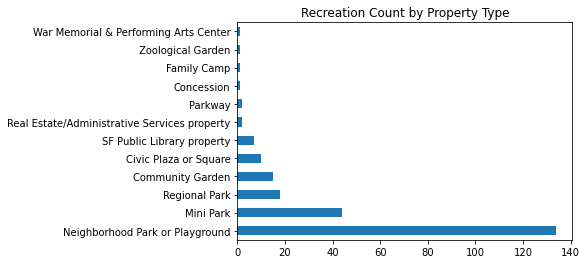

In [150]:
# Wanted to make a chart showing the count of each property type
# We see that Neighborhood Park or Playground, Mini Park, and Regional Park are the most frequent property type
# and they are the most relevant to us so we will isolate those later on
parkgeo['propertytype'].value_counts().plot.barh(title="Recreation Count by Property Type")

In [151]:
parkgeo.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 236 entries, 0 to 235
Data columns (total 32 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   squarefeet             236 non-null    object  
 1   state_assembly         234 non-null    object  
 2   city                   236 non-null    object  
 3   zipcode                236 non-null    object  
 4   acres                  236 non-null    object  
 5   propertytype           236 non-null    object  
 6   police_district        234 non-null    object  
 7   realtor_neighborhood   234 non-null    object  
 8   ggp_section            10 non-null     object  
 9   latitude               236 non-null    object  
 10  created_date           236 non-null    object  
 11  state                  236 non-null    object  
 12  mons_neighborhood      234 non-null    object  
 13  us_congress            234 non-null    object  
 14  land_id                235 non-nul

In [152]:
desired_columns = ['squarefeet',
'latitude',
'longitude',
 'propertytype',
'map_label',
'planning_neighborhood',
 'geometry']

In [153]:
park_trimmed = parkgeo[desired_columns]
park_trimmed

,squarefeet,latitude,longitude,propertytype,map_label,planning_neighborhood,geometry
0,87675.99885853,37.7955308,-122.39982015,Civic Plaza or Square,Maritime Plaza,Financial District,"MULTIPOLYGON (((-122.39908 37.79596, -122.3982..."
1,26505654.42121903,37.7219234,-122.49239745,Regional Park,Lake Merced Park,Lakeshore,"MULTIPOLYGON (((-122.48624 37.70816, -122.4862..."
2,6489.2547279,37.79642235,-122.41742016,Mini Park,Broadway Tunnel West Mini Park,Russian Hill,"MULTIPOLYGON (((-122.41757 37.79649, -122.4175..."
3,1773406.32935865,37.73906281,-122.45465821,Regional Park,Mt. Davidson Park,West of Twin Peaks,"MULTIPOLYGON (((-122.45309 37.74097, -122.4530..."
4,113243.32434104,37.78793123,-122.40750049,Civic Plaza or Square,Union Square,Downtown/Civic Center,"MULTIPOLYGON (((-122.40672 37.78765, -122.4074..."
...,...,...,...,...,...,...,...
231,57042.85874534,37.74183309,-122.46507086,Neighborhood Park or Playground,West Portal Playground,West of Twin Peaks,"MULTIPOLYGON (((-122.46511 37.74139, -122.4651..."
232,280760.64752792,37.73876902,-122.38448964,Neighborhood Park or Playground,Youngblood-Coleman Playground,Bayview,"MULTIPOLYGON (((-122.38339 37.73905, -122.3834..."
233,22631.2376498,37.71262615,-122.46421929,Mini Park,Head & Brotherood Mini Park,Ocean View,"MULTIPOLYGON (((-122.46371 37.71242, -122.4637..."
234,209915.57112574,37.8019919,-122.40620398,Civic Plaza or Square,Telegraph Hill - Pioneer Park,North Beach,"MULTIPOLYGON (((-122.40655 37.80261, -122.4064..."


In [154]:
# Looking at just those properties that are neighborhood parks or playgrounds and saving the new dataframe
park_neighborhoodparks = park_trimmed[park_trimmed.propertytype == 'Neighborhood Park or Playground']
park_neighborhoodparks

,squarefeet,latitude,longitude,propertytype,map_label,planning_neighborhood,geometry
5,97836.24218973,37.74706105,-122.41204637,Neighborhood Park or Playground,Precita Park,Bernal Heights,"MULTIPOLYGON (((-122.41327 37.74682, -122.4133..."
9,624724.30477121,37.72247455,-122.4139202,Neighborhood Park or Playground,Louis Sutter Playground,Excelsior,"MULTIPOLYGON (((-122.41257 37.72272, -122.4121..."
11,3459.10725366,37.73880227,-122.43431342,Neighborhood Park or Playground,Diamond & Farnum Open Space,Glen Park,"MULTIPOLYGON (((-122.43447 37.73876, -122.4345..."
12,6510.58816092,37.79733829,-122.44485143,Neighborhood Park or Playground,Cow Hollow Playground,Marina,"MULTIPOLYGON (((-122.44504 37.79736, -122.4450..."
14,296262.05679892,37.71347574,-122.41658008,Neighborhood Park or Playground,Herz Playground,Visitacion Valley,"MULTIPOLYGON (((-122.41767 37.71351, -122.4174..."
...,...,...,...,...,...,...,...
229,194805.34309802,37.79577739,-122.39751884,Neighborhood Park or Playground,Sue Bierman Park,Financial District,"MULTIPOLYGON (((-122.39729 37.79600, -122.3972..."
230,113312.94313497,37.73366439,-122.44746419,Neighborhood Park or Playground,Sunnyside Playground,Outer Mission,"MULTIPOLYGON (((-122.44828 37.73422, -122.4482..."
231,57042.85874534,37.74183309,-122.46507086,Neighborhood Park or Playground,West Portal Playground,West of Twin Peaks,"MULTIPOLYGON (((-122.46511 37.74139, -122.4651..."
232,280760.64752792,37.73876902,-122.38448964,Neighborhood Park or Playground,Youngblood-Coleman Playground,Bayview,"MULTIPOLYGON (((-122.38339 37.73905, -122.3834..."


In [155]:
# Looking at just those properties that are regional parks and saving the new dataframe
park_regional = park_trimmed[park_trimmed.propertytype == 'Regional Park']
park_regional

,squarefeet,latitude,longitude,propertytype,map_label,planning_neighborhood,geometry
1,26505654.42121903,37.7219234,-122.49239745,Regional Park,Lake Merced Park,Lakeshore,"MULTIPOLYGON (((-122.48624 37.70816, -122.4862..."
3,1773406.32935865,37.73906281,-122.45465821,Regional Park,Mt. Davidson Park,West of Twin Peaks,"MULTIPOLYGON (((-122.45309 37.74097, -122.4530..."
6,13614042.06931684,37.71808411,-122.4190781,Regional Park,John McLaren Park,Excelsior,"MULTIPOLYGON (((-122.41546 37.71339, -122.4154..."
23,2377861.95640328,37.75234399,-122.4469545,Regional Park,Twin Peaks,Twin Peaks,"MULTIPOLYGON (((-122.44460 37.75639, -122.4445..."
44,17846133.40641851,37.62395214,-122.47497421,Regional Park,Sharp Park,None,"MULTIPOLYGON (((-122.47844 37.62710, -122.4758..."
51,3394904.52732998,37.74020594,-122.44266629,Regional Park,Glen Canyon Park,Outer Mission,"MULTIPOLYGON (((-122.44441 37.74303, -122.4440..."
54,4913764.68623183,37.78423976,-122.49831499,Regional Park,Lincoln Park,Seacliff,"MULTIPOLYGON (((-122.50060 37.78610, -122.5001..."
56,2031399.00740282,37.71517987,-122.39250136,Regional Park,Bay View Park,Bayview,"MULTIPOLYGON (((-122.39442 37.71849, -122.3944..."
92,7206820.35007809,37.80795776,-122.44117884,Regional Park,Yacht Harbor and Marina Green,Marina,"MULTIPOLYGON (((-122.43677 37.81117, -122.4362..."
114,1514502.33247866,37.73609308,-122.47828163,Regional Park,Sigmund Stern Recreation Grove,Lakeshore,"MULTIPOLYGON (((-122.47530 37.73482, -122.4753..."


In [156]:
# Looking at just those properties that are mini parks and saving the new dataframe
park_mini = park_trimmed[park_trimmed.propertytype == 'Mini Park']
park_mini

,squarefeet,latitude,longitude,propertytype,map_label,planning_neighborhood,geometry
2,6489.2547279,37.79642235,-122.41742016,Mini Park,Broadway Tunnel West Mini Park,Russian Hill,"MULTIPOLYGON (((-122.41757 37.79649, -122.4175..."
7,19618.77719044,37.74607639,-122.40880709,Mini Park,Mullen & Peralta Mini Park,Bernal Heights,"MULTIPOLYGON (((-122.40899 37.74633, -122.4089..."
10,12782.70879409,37.72044197,-122.44544775,Mini Park,Geneva Community Garden,Outer Mission,"MULTIPOLYGON (((-122.44514 37.72024, -122.4451..."
13,6555.17547189,37.74624354,-122.41812033,Mini Park,Coso & Precita Mini Park,Bernal Heights,"MULTIPOLYGON (((-122.41794 37.74603, -122.4179..."
22,22426.60058509,37.71809145,-122.46257271,Mini Park,Lakeview & Ashton Mini Park,Ocean View,"MULTIPOLYGON (((-122.46274 37.71800, -122.4628..."
36,7354.49061121,37.70861819,-122.45532293,Mini Park,Lessing & Sears Mini Park,Outer Mission,"MULTIPOLYGON (((-122.45524 37.70845, -122.4555..."
46,6156.50549517,37.7327328,-122.4408417,Mini Park,Joost & Baden Mini Park,Outer Mission,"MULTIPOLYGON (((-122.44079 37.73242, -122.4407..."
68,5800.06998092,37.753044,-122.40857387,Mini Park,24th & York Mini Park,Mission,"MULTIPOLYGON (((-122.40847 37.75289, -122.4086..."
76,9787.10714327,37.75739557,-122.3966542,Mini Park,Potrero Hill Mini Park,Potrero Hill,"MULTIPOLYGON (((-122.39686 37.75734, -122.3971..."
80,3821.01075951,37.78240439,-122.43859838,Mini Park,Beideman & O'Farrell Mini Park,Western Addition,"MULTIPOLYGON (((-122.43868 37.78232, -122.4387..."


In [157]:
# Take three seperate dataframes and merge them together
# First combining the neighborhood parks and regional parks
park_combined = park_regional.append(park_neighborhoodparks, ignore_index = True)

In [158]:
# Next, merging that combined dataframe with the mini parks
park_final = park_combined.append(park_mini, ignore_index = True)

In [159]:
# Now that we have this new merged dataframe
# I wanted to make a chart showing the count of parks in each neighborhood 
px.bar(park_final, x=('planning_neighborhood'), 
       title='Number of Parks in San Francisco by Neighborhood',
       labels={'planning_neighborhood':'Neighborhood','count':'Count'})

This helps us to compare the neighborhoods with the most/least crime to the neighborhoods with the most/least parks.

In [160]:
# Converting Lat and Lon to float
park_final['latitude'] = park_final['latitude'].astype(float)
park_final['longitude'] = park_final['longitude'].astype(float)
park_final.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 196 entries, 0 to 195
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   squarefeet             196 non-null    object  
 1   latitude               196 non-null    float64 
 2   longitude              196 non-null    float64 
 3   propertytype           196 non-null    object  
 4   map_label              196 non-null    object  
 5   planning_neighborhood  195 non-null    object  
 6   geometry               196 non-null    geometry
dtypes: float64(2), geometry(1), object(4)
memory usage: 10.8+ KB


## Create an Interactive Map using Kepler

In [161]:
map = KeplerGl(height=600,width=800)
map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(height=600)

In [162]:
# Couldn't get the park data to plot on Kepler so I decided to make a smaller subset
park_subset = park_final[['map_label','latitude','longitude','propertytype']].copy()
park_subset.head()

,map_label,latitude,longitude,propertytype
0,Lake Merced Park,37.721923,-122.492397,Regional Park
1,Mt. Davidson Park,37.739063,-122.454658,Regional Park
2,John McLaren Park,37.718084,-122.419078,Regional Park
3,Twin Peaks,37.752344,-122.446955,Regional Park
4,Sharp Park,37.623952,-122.474974,Regional Park


In [163]:
park_subset['latitude'] = park_subset['latitude'].astype(float)
park_subset['longitude'] = park_subset['longitude'].astype(float)
park_subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196 entries, 0 to 195
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   map_label     196 non-null    object 
 1   latitude      196 non-null    float64
 2   longitude     196 non-null    float64
 3   propertytype  196 non-null    object 
dtypes: float64(2), object(2)
memory usage: 6.2+ KB


In [164]:
map.add_data(data=park_subset,name='Parks')

The Kepler map is nice because it is interactive. We can zoom in and out and see the name of each park as well as property type.

In [165]:
map.save_to_html(file_name='kepler_park_map.html')

Map saved to kepler_park_map.html!


# Now to introduce neighborhood boundaries data

In [166]:
neighborhoods.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 117 entries, 0 to 116
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   link      93 non-null     object  
 1   name      117 non-null    object  
 2   geometry  117 non-null    geometry
dtypes: geometry(1), object(2)
memory usage: 2.9+ KB


In [167]:
# trim the neighborhood data to the bare minimum columns
neighborhoods = neighborhoods[['name','geometry']]
neighborhoods.head()

,name,geometry
0,Seacliff,"MULTIPOLYGON (((-122.49346 37.78352, -122.4937..."
1,Lake Street,"MULTIPOLYGON (((-122.48715 37.78379, -122.4872..."
2,Presidio National Park,"MULTIPOLYGON (((-122.47758 37.81099, -122.4771..."
3,Presidio Terrace,"MULTIPOLYGON (((-122.47241 37.78735, -122.4710..."
4,Inner Richmond,"MULTIPOLYGON (((-122.47263 37.78631, -122.4668..."


In [168]:
# reproject to web mercator
neighborhoods = neighborhoods.to_crs(epsg=3857)

In [170]:
type(park_final)

geopandas.geodataframe.GeoDataFrame

In [171]:
park_final.sample()

,squarefeet,latitude,longitude,propertytype,map_label,planning_neighborhood,geometry
63,117435.90651431,37.777004,-122.405966,Neighborhood Park or Playground,Victoria Manalo Draves Park,South of Market,"MULTIPOLYGON (((-122.40556 37.77708, -122.4050..."


In [172]:
# get the layers into a web mercator projection
# reproject to web mercator
park_final = park_final.to_crs(epsg=3857)

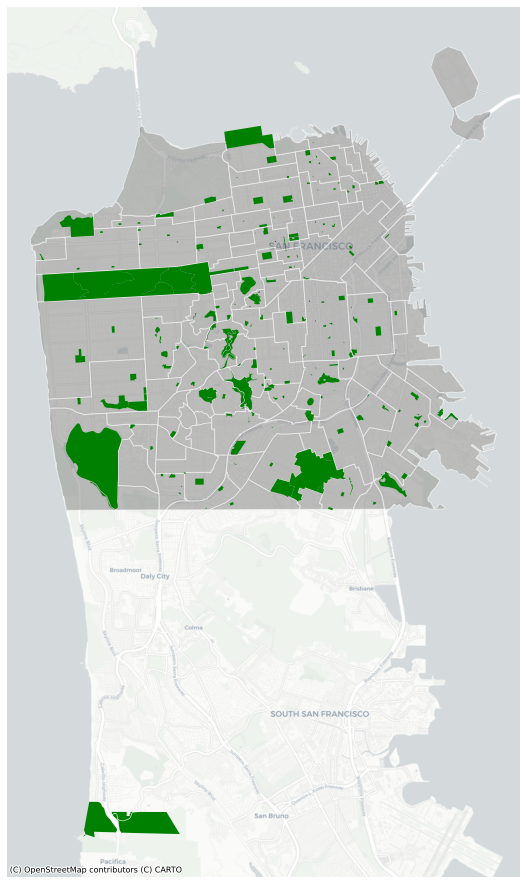

In [179]:
# defining the base layer
base = neighborhoods.plot(figsize=(16,16),
                      color='gray', 
                      edgecolor='white',
                      alpha=0.5)

# define the layer that will go on top, and add the base layer to the `ax` argument
ax = park_final.plot(ax=base, color='green', markersize=5)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)


In [180]:
neighborhoods.geometry.total_bounds

array([-13638295.97445647,   4538270.28598231, -13620716.9299059 ,
         4555775.96673832])

In [181]:
minx, miny, maxx, maxy = neighborhoods.geometry.total_bounds
print(minx)
print(maxx)
print(miny)
print(maxy)

-13638295.97445647
-13620716.929905897
4538270.285982309
4555775.966738317


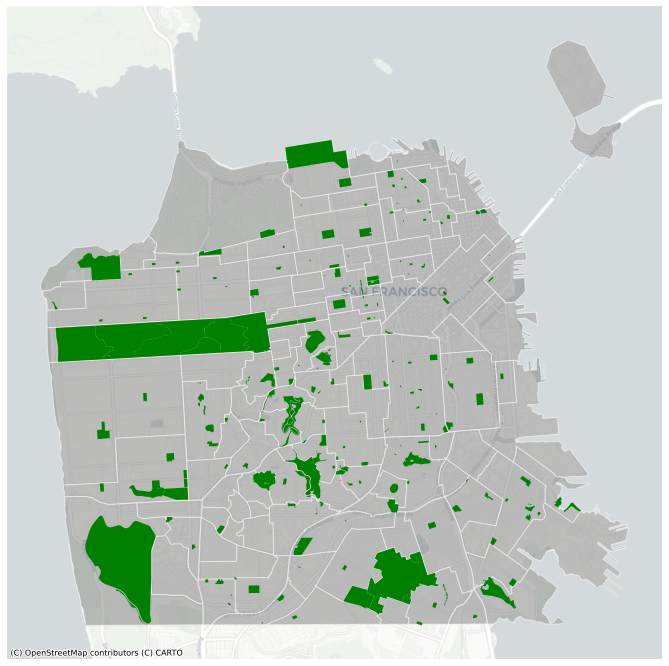

In [192]:
# use the bounding box coordinates to set the x and y limits
base = neighborhoods.plot(figsize=(12,12),
                          color='gray', 
                          edgecolor='white',
                          alpha=0.5)

ax = park_final.plot(ax=base, 
                color='green', 
                markersize=5
               )

base.set_xlim(minx - 1000, maxx + 1000)
base.set_ylim(miny - 1000, maxy + 1000)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

ax

In [211]:
def map_parks_by_neighborhood(place='Nob Hill'):
    
    neighborhood = neighborhoods[neighborhoods.name==place]

    minx, miny, maxx, maxy = neighborhood.geometry.total_bounds

    parks_in_neighborhood = gpd.sjoin(park_final,neighborhood,how='inner')

    base = neighborhood.plot(figsize=(12,12),
                             color='green', 
                             edgecolor='green',
                             alpha=0.1)

    ax = parks_in_neighborhood.plot(ax=base,
                                    column='map_label',
                                    markersize=40, 
                                    legend=True,
                                    cmap='tab20',
                                    legend_kwds={
                                       'loc': 'upper right',
                                       'bbox_to_anchor':(1.3,1)
                                    }                  
                                )
    
    base.set_xlim(minx - 200, maxx + 200) 
    base.set_ylim(miny - 200, maxy + 200)

    # turn off the axis
    ax.axis('off')

    # add a title
    ax.set_title('Parks in '+neighborhood.name.values[0]+' San Francisco',fontsize=20)

    # add a basemap
    ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)
    ax

In [212]:
list(neighborhoods.name)
   

['Seacliff',
 'Lake Street',
 'Presidio National Park',
 'Presidio Terrace',
 'Inner Richmond',
 'Sutro Heights',
 'Lincoln Park / Ft. Miley',
 'Outer Richmond',
 'Golden Gate Park',
 'Presidio Heights',
 'Laurel Heights / Jordan Park',
 'Lone Mountain',
 'Anza Vista',
 'Cow Hollow',
 'Union Street',
 'Nob Hill',
 'Marina',
 'Telegraph Hill',
 'Downtown / Union Square',
 'Tenderloin',
 'Civic Center',
 'Hayes Valley',
 'Alamo Square',
 'Panhandle',
 'Haight Ashbury',
 'Lower Haight',
 'Mint Hill',
 'Duboce Triangle',
 'Cole Valley',
 'Rincon Hill',
 'South Beach',
 'South of Market',
 'Showplace Square',
 'Mission Bay',
 'Yerba Buena Island',
 'Treasure Island',
 'Mission Dolores',
 'Castro',
 'Outer Sunset',
 'Parkside',
 'Stonestown',
 'Parkmerced',
 'Lakeshore',
 'Golden Gate Heights',
 'Forest Hill',
 'West Portal',
 'Clarendon Heights',
 'Midtown Terrace',
 'Laguna Honda',
 'Lower Nob Hill',
 'Upper Market',
 'Dolores Heights',
 'Mission',
 'Potrero Hill',
 'Dogpatch',
 'Central W

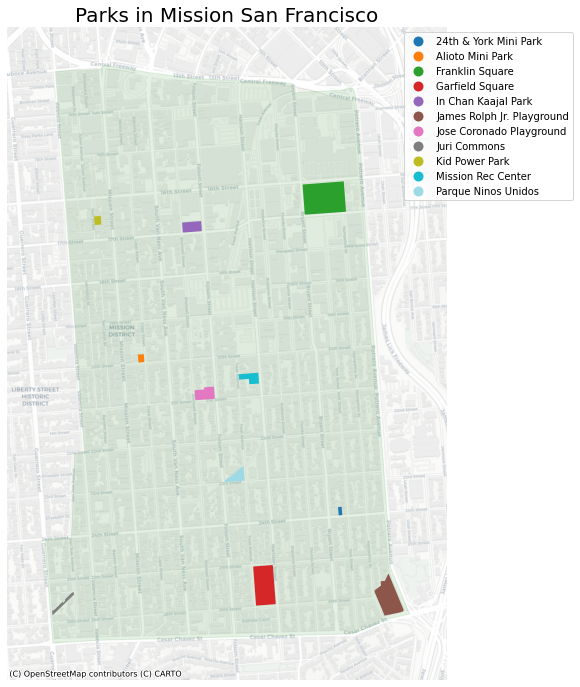

In [214]:
# calling the function
map_parks_by_neighborhood(place='Mission')

# Contributions
Sarah D. is responsible for all parks data and visualizations. 